In [ ]:
%pip install numpy

In [6]:
import numpy as np
print(np.__version__)

1.23.1


In [ ]:
%pip install statsmodels==0.11
# %pip install --upgrade pip

In [ ]:
%pip install matplotlib

In [12]:
# Note: The information criteria add 1 to the number of parameters
#       whenever the model has an AR or MA term since, in principle,
#       the variance could be treated as a free parameter and restricted
#       This code does not allow this, but it adds consistency with other
#       packages such as gretl and X12-ARIMA
 
from __future__ import absolute_import
# from statsmodels.compat.python import string_types, range
string_types = str

# for 2to3 with extensions
 
from datetime import datetime
 
import numpy as np
from scipy import optimize
from scipy.stats import t, norm
from scipy.signal import lfilter
from numpy import dot, log, zeros, pi
from numpy.linalg import inv
 
from statsmodels.tools.decorators import (cache_readonly,
                                          resettable_cache)
import statsmodels.tsa.base.tsa_model as tsbase
import statsmodels.base.wrapper as wrap
from statsmodels.regression.linear_model import yule_walker, GLS
from statsmodels.tsa.tsatools import (lagmat, add_trend,
                                      _ar_transparams, _ar_invtransparams,
                                      _ma_transparams, _ma_invtransparams,
                                      unintegrate, unintegrate_levels)
from statsmodels.tsa.vector_ar import util
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_process import arma2ma
from statsmodels.tools.numdiff import approx_hess_cs, approx_fprime_cs
from statsmodels.tsa.base.datetools import _index_date
from statsmodels.tsa.kalmanf import KalmanFilter
 
_armax_notes = """
 
        Notes
        -----
        If exogenous variables are given, then the model that is fit is
 
        .. math::
 
           \\phi(L)(y_t - X_t\\beta) = \\theta(L)\epsilon_t
 
        where :math:`\\phi` and :math:`\\theta` are polynomials in the lag
        operator, :math:`L`. This is the regression model with ARMA errors,
        or ARMAX model. This specification is used, whether or not the model
        is fit using conditional sum of square or maximum-likelihood, using
        the `method` argument in
        :meth:`statsmodels.tsa.arima_model.%(Model)s.fit`. Therefore, for
        now, `css` and `mle` refer to estimation methods only. This may
        change for the case of the `css` model in future versions.
"""
 
_arma_params = """\
    endog : array-like
        The endogenous variable.
    order : iterable
        The (p,q) order of the model for the number of AR parameters,
        differences, and MA parameters to use.
    exog : array-like, optional
        An optional arry of exogenous variables. This should *not* include a
        constant or trend. You can specify this in the `fit` method."""
 
_arma_model = "Autoregressive Moving Average ARMA(p,q) Model"
 
_arima_model = "Autoregressive Integrated Moving Average ARIMA(p,d,q) Model"
 
_arima_params = """\
    endog : array-like
        The endogenous variable.
    order : iterable
        The (p,d,q) order of the model for the number of AR parameters,
        differences, and MA parameters to use.
    exog : array-like, optional
        An optional arry of exogenous variables. This should *not* include a
        constant or trend. You can specify this in the `fit` method."""
 
_predict_notes = """
        Notes
        -----
        Use the results predict method instead.
"""
 
_results_notes = """
        Notes
        -----
        It is recommended to use dates with the time-series models, as the
        below will probably make clear. However, if ARIMA is used without
        dates and/or `start` and `end` are given as indices, then these
        indices are in terms of the *original*, undifferenced series. Ie.,
        given some undifferenced observations::
 
         1970Q1, 1
         1970Q2, 1.5
         1970Q3, 1.25
         1970Q4, 2.25
         1971Q1, 1.2
         1971Q2, 4.1
 
        1970Q1 is observation 0 in the original series. However, if we fit an
        ARIMA(p,1,q) model then we lose this first observation through
        differencing. Therefore, the first observation we can forecast (if
        using exact MLE) is index 1. In the differenced series this is index
        0, but we refer to it as 1 from the original series.
"""
 
_predict = """
        %(Model)s model in-sample and out-of-sample prediction
 
        Parameters
        ----------
        %(params)s
        start : int, str, or datetime
            Zero-indexed observation number at which to start forecasting, ie.,
            the first forecast is start. Can also be a date string to
            parse or a datetime type.
        end : int, str, or datetime
            Zero-indexed observation number at which to end forecasting, ie.,
            the first forecast is start. Can also be a date string to
            parse or a datetime type. However, if the dates index does not
            have a fixed frequency, end must be an integer index if you
            want out of sample prediction.
        exog : array-like, optional
            If the model is an ARMAX and out-of-sample forecasting is
            requested, exog must be given. Note that you'll need to pass
            `k_ar` additional lags for any exogenous variables. E.g., if you
            fit an ARMAX(2, q) model and want to predict 5 steps, you need 7
            observations to do this.
        dynamic : bool, optional
            The `dynamic` keyword affects in-sample prediction. If dynamic
            is False, then the in-sample lagged values are used for
            prediction. If `dynamic` is True, then in-sample forecasts are
            used in place of lagged dependent variables. The first forecasted
            value is `start`.
        %(extra_params)s
 
        Returns
        -------
        %(returns)s
        %(extra_section)s
"""
 
_predict_returns = """predict : array
            The predicted values.
 
"""
 
_arma_predict = _predict % {"Model" : "ARMA",
                            "params" : """
            params : array-like
            The fitted parameters of the model.""",
                            "extra_params" : "",
                            "returns" : _predict_returns,
                            "extra_section" : _predict_notes}
 
_arma_results_predict = _predict % {"Model" : "ARMA", "params" : "",
                                    "extra_params" : "",
                                    "returns" : _predict_returns,
                                    "extra_section" : _results_notes}
 
_arima_predict = _predict % {"Model" : "ARIMA",
                             "params" : """params : array-like
            The fitted parameters of the model.""",
                             "extra_params" : """typ : str {'linear', 'levels'}
 
            - 'linear' : Linear prediction in terms of the differenced
              endogenous variables.
            - 'levels' : Predict the levels of the original endogenous
              variables.\n""", "returns" : _predict_returns,
                             "extra_section" : _predict_notes}
 
_arima_results_predict = _predict % {"Model" : "ARIMA",
                                     "params" : "",
                                     "extra_params" :
                                     """typ : str {'linear', 'levels'}
 
            - 'linear' : Linear prediction in terms of the differenced
              endogenous variables.
            - 'levels' : Predict the levels of the original endogenous
              variables.\n""",
                                     "returns" : _predict_returns,
                                     "extra_section" : _results_notes}
 
_arima_plot_predict_example = """        Examples
        --------
        >>> import statsmodels.api as sm
        >>> import matplotlib.pyplot as plt
        >>> import pandas as pd
        >>>
        >>> dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
        >>> dta.index = pd.DatetimeIndex(start='1700', end='2009', freq='A')
        >>> res = sm.tsa.ARMA(dta, (3, 0)).fit()
        >>> fig, ax = plt.subplots()
        >>> ax = dta.ix['1950':].plot(ax=ax)
        >>> fig = res.plot_predict('1990', '2012', dynamic=True, ax=ax,
        ...                        plot_insample=False)
        >>> plt.show()
 
        .. plot:: plots/arma_predict_plot.py
"""
 
_plot_predict = ("""
        Plot forecasts
                      """ + '\n'.join(_predict.split('\n')[2:])) % {
                      "params" : "",
                          "extra_params" : """alpha : float, optional
            The confidence intervals for the forecasts are (1 - alpha)%
        plot_insample : bool, optional
            Whether to plot the in-sample series. Default is True.
        ax : matplotlib.Axes, optional
            Existing axes to plot with.""",
                      "returns" : """fig : matplotlib.Figure
            The plotted Figure instance""",
                      "extra_section" : ('\n' + _arima_plot_predict_example +
                                         '\n' + _results_notes)
                      }
 
_arima_plot_predict = ("""
        Plot forecasts
                      """ + '\n'.join(_predict.split('\n')[2:])) % {
                      "params" : "",
                          "extra_params" : """alpha : float, optional
            The confidence intervals for the forecasts are (1 - alpha)%
        plot_insample : bool, optional
            Whether to plot the in-sample series. Default is True.
        ax : matplotlib.Axes, optional
            Existing axes to plot with.""",
                      "returns" : """fig : matplotlib.Figure
            The plotted Figure instance""",
                "extra_section" : ('\n' + _arima_plot_predict_example +
                                   '\n' +
                                   '\n'.join(_results_notes.split('\n')[:3]) +
                              ("""
        This is hard-coded to only allow plotting of the forecasts in levels.
""") +
                              '\n'.join(_results_notes.split('\n')[3:]))
                      }
 
 
def cumsum_n(x, n):
    if n:
        n -= 1
        x = np.cumsum(x)
        return cumsum_n(x, n)
    else:
        return x
 
 
def _check_arima_start(start, k_ar, k_diff, method, dynamic):
    if start < 0:
        raise ValueError("The start index %d of the original series "
                         "has been differenced away" % start)
    elif (dynamic or 'mle' not in method) and start < k_ar:
        raise ValueError("Start must be >= k_ar for conditional MLE "
                         "or dynamic forecast. Got %d" % start)
 
 
def _get_predict_out_of_sample(endog, p, q, k_trend, k_exog, start, errors,
                               trendparam, exparams, arparams, maparams, steps,
                               method, exog=None):
    """
    Returns endog, resid, mu of appropriate length for out of sample
    prediction.
    """
    if q:
        resid = np.zeros(q)
        if start and 'mle' in method or (start == p and not start == 0):
            resid[:q] = errors[start-q:start]
        elif start:
            resid[:q] = errors[start-q-p:start-p]
        else:
            resid[:q] = errors[-q:]
    else:
        resid = None
 
    y = endog
    if k_trend == 1:
        # use expectation not constant
        if k_exog > 0:
            #TODO: technically should only hold for MLE not
            # conditional model. See #274.
            # ensure 2-d for conformability
            if np.ndim(exog) == 1 and k_exog == 1:
                # have a 1d series of observations -> 2d
                exog = exog[:, None]
            elif np.ndim(exog) == 1:
                # should have a 1d row of exog -> 2d
                if len(exog) != k_exog:
                    raise ValueError("1d exog given and len(exog) != k_exog")
                exog = exog[None, :]
            X = lagmat(np.dot(exog, exparams), p, original='in', trim='both')
            mu = trendparam * (1 - arparams.sum())
            # arparams were reversed in unpack for ease later
            mu = mu + (np.r_[1, -arparams[::-1]] * X).sum(1)[:, None]
        else:
            mu = trendparam * (1 - arparams.sum())
            mu = np.array([mu]*steps)
    elif k_exog > 0:
        X = np.dot(exog, exparams)
        #NOTE: you shouldn't have to give in-sample exog!
        X = lagmat(X, p, original='in', trim='both')
        mu = (np.r_[1, -arparams[::-1]] * X).sum(1)[:, None]
    else:
        mu = np.zeros(steps)
 
    endog = np.zeros(p + steps - 1)
 
    if p and start:
        endog[:p] = y[start-p:start]
    elif p:
        endog[:p] = y[-p:]
 
    return endog, resid, mu
 
 
def _arma_predict_out_of_sample(params, steps, errors, p, q, k_trend, k_exog,
                                endog, exog=None, start=0, method='mle'):
    (trendparam, exparams,
     arparams, maparams) = _unpack_params(params, (p, q), k_trend,
                                          k_exog, reverse=True)
 #   print 'params:',params
 #   print 'arparams:',arparams,'maparams:',maparams
    endog, resid, mu = _get_predict_out_of_sample(endog, p, q, k_trend, k_exog,
                                                  start, errors, trendparam,
                                                  exparams, arparams,
                                                  maparams, steps, method,
                                                  exog)
#    print 'mu[-1]:',mu[-1], 'mu[0]:',mu[0]
    forecast = np.zeros(steps)
    if steps == 1:
        if q:
            return mu[0] + np.dot(arparams, endog[:p]) + np.dot(maparams,
                                                                resid[:q]), mu[0]
        else:
            return mu[0] + np.dot(arparams, endog[:p]), mu[0]
 
    if q:
        i = 0  # if q == 1
    else:
        i = -1
 
    for i in range(min(q, steps - 1)):
        fcast = (mu[i] + np.dot(arparams, endog[i:i + p]) +
                 np.dot(maparams[:q - i], resid[i:i + q]))
        forecast[i] = fcast
        endog[i+p] = fcast
 
    for i in range(i + 1, steps - 1):
        fcast = mu[i] + np.dot(arparams, endog[i:i+p])
        forecast[i] = fcast
        endog[i+p] = fcast
 
    #need to do one more without updating endog
    forecast[-1] = mu[-1] + np.dot(arparams, endog[steps - 1:])
    return forecast, mu[-1] #Modified by me, the former is return forecast
 
 
def _arma_predict_in_sample(start, end, endog, resid, k_ar, method):
    """
    Pre- and in-sample fitting for ARMA.
    """
    if 'mle' in method:
        fittedvalues = endog - resid  # get them all then trim
    else:
        fittedvalues = endog[k_ar:] - resid
 
    fv_start = start
    if 'mle' not in method:
        fv_start -= k_ar  # start is in terms of endog index
    fv_end = min(len(fittedvalues), end + 1)
    return fittedvalues[fv_start:fv_end]
 
 
def _validate(start, k_ar, k_diff, dates, method):
    if isinstance(start, (string_types, datetime)):
        start = _index_date(start, dates)
        start -= k_diff
    if 'mle' not in method and start < k_ar - k_diff:
        raise ValueError("Start must be >= k_ar for conditional "
                         "MLE or dynamic forecast. Got %s" % start)
 
    return start
 
 
def _unpack_params(params, order, k_trend, k_exog, reverse=False):
    p, q = order
    k = k_trend + k_exog
    maparams = params[k+p:]
    arparams = params[k:k+p]
    trend = params[:k_trend]
    exparams = params[k_trend:k]
    if reverse:
        return trend, exparams, arparams[::-1], maparams[::-1]
    return trend, exparams, arparams, maparams
 
 
def _unpack_order(order):
    k_ar, k_ma, k = order
    k_lags = max(k_ar, k_ma+1)
    return k_ar, k_ma, order, k_lags
 
 
def _make_arma_names(data, k_trend, order, exog_names):
    k_ar, k_ma = order
    exog_names = exog_names or []
    ar_lag_names = util.make_lag_names([data.ynames], k_ar, 0)
    ar_lag_names = [''.join(('ar.', i)) for i in ar_lag_names]
    ma_lag_names = util.make_lag_names([data.ynames], k_ma, 0)
    ma_lag_names = [''.join(('ma.', i)) for i in ma_lag_names]
    trend_name = util.make_lag_names('', 0, k_trend)
    exog_names = trend_name + exog_names + ar_lag_names + ma_lag_names
    return exog_names
 
 
def _make_arma_exog(endog, exog, trend):
    k_trend = 1  # overwritten if no constant
    if exog is None and trend == 'c':   # constant only
        exog = np.ones((len(endog), 1))
    elif exog is not None and trend == 'c':  # constant plus exogenous
        exog = add_trend(exog, trend='c', prepend=True)
    elif exog is not None and trend == 'nc':
        # make sure it's not holding constant from last run
        if exog.var() == 0:
            exog = None
        k_trend = 0
    if trend == 'nc':
        k_trend = 0
    return k_trend, exog
 
 
def _check_estimable(nobs, n_params):
    if nobs <= n_params:
        raise ValueError("Insufficient degrees of freedom to estimate")
 
 
class ARMA(tsbase.TimeSeriesModel):
 
    __doc__ = tsbase._tsa_doc % {"model" : _arma_model,
                                 "params" : _arma_params, "extra_params" : "",
                                 "extra_sections" : _armax_notes %
                                 {"Model" : "ARMA"}}
 
    def __init__(self, endog, order, exog=None, dates=None, freq=None,
                 missing='none'):
        super(ARMA, self).__init__(endog, exog, dates, freq, missing=missing)
        exog = self.data.exog  # get it after it's gone through processing
        _check_estimable(len(self.endog), sum(order))
        self.k_ar = k_ar = order[0]
        self.k_ma = k_ma = order[1]
        self.k_lags = max(k_ar, k_ma+1)
        self.constant = 0 #Added by me
        if exog is not None:
            if exog.ndim == 1:
                exog = exog[:, None]
            k_exog = exog.shape[1]  # number of exog. variables excl. const
        else:
            k_exog = 0
        self.k_exog = k_exog
 
    def _fit_start_params_hr(self, order):
        """
        Get starting parameters for fit.
 
        Parameters
        ----------
        order : iterable
            (p,q,k) - AR lags, MA lags, and number of exogenous variables
            including the constant.
 
        Returns
        -------
        start_params : array
            A first guess at the starting parameters.
 
        Notes
        -----
        If necessary, fits an AR process with the laglength selected according
        to best BIC.  Obtain the residuals.  Then fit an ARMA(p,q) model via
        OLS using these residuals for a first approximation.  Uses a separate
        OLS regression to find the coefficients of exogenous variables.
 
        References
        ----------
        Hannan, E.J. and Rissanen, J.  1982.  "Recursive estimation of mixed
            autoregressive-moving average order."  `Biometrika`.  69.1.
        """
        p, q, k = order
        start_params = zeros((p+q+k))
        endog = self.endog.copy()  # copy because overwritten
        exog = self.exog
        if k != 0:
            ols_params = GLS(endog, exog).fit().params
            start_params[:k] = ols_params
            endog -= np.dot(exog, ols_params).squeeze()
        if q != 0:
            if p != 0:
                # make sure we don't run into small data problems in AR fit
                nobs = len(endog)
                maxlag = int(round(12*(nobs/100.)**(1/4.)))
                if maxlag >= nobs:
                    maxlag = nobs - 1
                armod = AR(endog).fit(ic='bic', trend='nc', maxlag=maxlag)
                arcoefs_tmp = armod.params
                p_tmp = armod.k_ar
                # it's possible in small samples that optimal lag-order
                # doesn't leave enough obs. No consistent way to fix.
                if p_tmp + q >= len(endog):
                    raise ValueError("Proper starting parameters cannot"
                                     " be found for this order with this "
                                     "number of observations. Use the "
                                     "start_params argument.")
                resid = endog[p_tmp:] - np.dot(lagmat(endog, p_tmp,
                                                      trim='both'),
                                               arcoefs_tmp)
                if p < p_tmp + q:
                    endog_start = p_tmp + q - p
                    resid_start = 0
                else:
                    endog_start = 0
                    resid_start = p - p_tmp - q
                lag_endog = lagmat(endog, p, 'both')[endog_start:]
                lag_resid = lagmat(resid, q, 'both')[resid_start:]
                # stack ar lags and resids
                X = np.column_stack((lag_endog, lag_resid))
                coefs = GLS(endog[max(p_tmp + q, p):], X).fit().params
                start_params[k:k+p+q] = coefs
            else:
                start_params[k+p:k+p+q] = yule_walker(endog, order=q)[0]
        if q == 0 and p != 0:
            arcoefs = yule_walker(endog, order=p)[0]
            start_params[k:k+p] = arcoefs
 
        # check AR coefficients
        if p and not np.all(np.abs(np.roots(np.r_[1, -start_params[k:k + p]]
                                            )) < 1):
            raise ValueError("The computed initial AR coefficients are not "
                             "stationary\nYou should induce stationarity, "
                             "choose a different model order, or you can\n"
                             "pass your own start_params.")
        # check MA coefficients
        elif q and not np.all(np.abs(np.roots(np.r_[1, start_params[k + p:]]
                                              )) < 1):
            return np.zeros(len(start_params))   #modified by me
            raise ValueError("The computed initial MA coefficients are not "
                             "invertible\nYou should induce invertibility, "
                             "choose a different model order, or you can\n"
                             "pass your own start_params.")
 
        # check MA coefficients
        # print start_params
        return start_params
 
    def _fit_start_params(self, order, method):
        if method != 'css-mle':  # use Hannan-Rissanen to get start params
            start_params = self._fit_start_params_hr(order)
        else:  # use CSS to get start params
            func = lambda params: -self.loglike_css(params)
            #start_params = [.1]*(k_ar+k_ma+k_exog) # different one for k?
            start_params = self._fit_start_params_hr(order)
            if self.transparams:
                start_params = self._invtransparams(start_params)
            bounds = [(None,)*2]*sum(order)
            mlefit = optimize.fmin_l_bfgs_b(func, start_params,
                                            approx_grad=True, m=12,
                                            pgtol=1e-7, factr=1e3,
                                            bounds=bounds, iprint=-1)
            start_params = self._transparams(mlefit[0])
        return start_params
 
    def score(self, params):
        """
        Compute the score function at params.
 
        Notes
        -----
        This is a numerical approximation.
        """
        return approx_fprime_cs(params, self.loglike, args=(False,))
 
    def hessian(self, params):
        """
        Compute the Hessian at params,
 
        Notes
        -----
        This is a numerical approximation.
        """
        return approx_hess_cs(params, self.loglike, args=(False,))
 
    def _transparams(self, params):
        """
        Transforms params to induce stationarity/invertability.
 
        Reference
        ---------
        Jones(1980)
        """
        k_ar, k_ma = self.k_ar, self.k_ma
        k = self.k_exog + self.k_trend
        newparams = np.zeros_like(params)
 
        # just copy exogenous parameters
        if k != 0:
            newparams[:k] = params[:k]
 
        # AR Coeffs
        if k_ar != 0:
            newparams[k:k+k_ar] = _ar_transparams(params[k:k+k_ar].copy())
 
        # MA Coeffs
        if k_ma != 0:
            newparams[k+k_ar:] = _ma_transparams(params[k+k_ar:].copy())
        return newparams
 
    def _invtransparams(self, start_params):
        """
        Inverse of the Jones reparameterization
        """
        k_ar, k_ma = self.k_ar, self.k_ma
        k = self.k_exog + self.k_trend
        newparams = start_params.copy()
        arcoefs = newparams[k:k+k_ar]
        macoefs = newparams[k+k_ar:]
        # AR coeffs
        if k_ar != 0:
            newparams[k:k+k_ar] = _ar_invtransparams(arcoefs)
 
        # MA coeffs
        if k_ma != 0:
            newparams[k+k_ar:k+k_ar+k_ma] = _ma_invtransparams(macoefs)
        return newparams
 
    def _get_predict_start(self, start, dynamic):
        # do some defaults
        method = getattr(self, 'method', 'mle')
        k_ar = getattr(self, 'k_ar', 0)
        k_diff = getattr(self, 'k_diff', 0)
        if start is None:
            if 'mle' in method and not dynamic:
                start = 0
            else:
                start = k_ar
            self._set_predict_start_date(start)  # else it's done in super
        elif isinstance(start, int):
            start = super(ARMA, self)._get_predict_start(start)
        else:  # should be on a date
            #elif 'mle' not in method or dynamic: # should be on a date
            start = _validate(start, k_ar, k_diff, self.data.dates,
                              method)
            start = super(ARMA, self)._get_predict_start(start)
        _check_arima_start(start, k_ar, k_diff, method, dynamic)
        return start
 
    def _get_predict_end(self, end, dynamic=False):
        # pass through so predict works for ARIMA and ARMA
        return super(ARMA, self)._get_predict_end(end)
 
    def geterrors(self, params):
        """
        Get the errors of the ARMA process.
 
        Parameters
        ----------
        params : array-like
            The fitted ARMA parameters
        order : array-like
            3 item iterable, with the number of AR, MA, and exogenous
            parameters, including the trend
        """
 
        #start = self._get_predict_start(start) # will be an index of a date
        #end, out_of_sample = self._get_predict_end(end)
        params = np.asarray(params)
        k_ar, k_ma = self.k_ar, self.k_ma
        k = self.k_exog + self.k_trend
 
        method = getattr(self, 'method', 'mle')
        if 'mle' in method:  # use KalmanFilter to get errors
            (y, k, nobs, k_ar, k_ma, k_lags, newparams, Z_mat, m, R_mat,
             T_mat, paramsdtype) = KalmanFilter._init_kalman_state(params,
                                                                   self)
 
            errors = KalmanFilter.geterrors(y, k, k_ar, k_ma, k_lags, nobs,
                                            Z_mat, m, R_mat, T_mat,
                                            paramsdtype)
            if isinstance(errors, tuple):
                errors = errors[0]  # non-cython version returns a tuple
        else:  # use scipy.signal.lfilter
            y = self.endog.copy()
            k = self.k_exog + self.k_trend
            if k > 0:
                y -= dot(self.exog, params[:k])
 
            k_ar = self.k_ar
            k_ma = self.k_ma
 
            (trendparams, exparams,
             arparams, maparams) = _unpack_params(params, (k_ar, k_ma),
                                                  self.k_trend, self.k_exog,
                                                  reverse=False)
            b, a = np.r_[1, -arparams], np.r_[1, maparams]
            zi = zeros((max(k_ar, k_ma)))
            for i in range(k_ar):
                zi[i] = sum(-b[:i+1][::-1]*y[:i+1])
            e = lfilter(b, a, y, zi=zi)
            errors = e[0][k_ar:]
        return errors.squeeze()
 
    def predict(self, params, start=None, end=None, exog=None, dynamic=False):
        method = getattr(self, 'method', 'mle')  # don't assume fit
        #params = np.asarray(params)
 
        # will return an index of a date
        start = self._get_predict_start(start, dynamic)
        end, out_of_sample = self._get_predict_end(end, dynamic)
        if out_of_sample and (exog is None and self.k_exog > 0):
            raise ValueError("You must provide exog for ARMAX")
 
        endog = self.endog
        resid = self.geterrors(params)
        k_ar = self.k_ar
 
        if out_of_sample != 0 and self.k_exog > 0:
            if self.k_exog == 1 and exog.ndim == 1:
                exog = exog[:, None]
                # we need the last k_ar exog for the lag-polynomial
            if self.k_exog > 0 and k_ar > 0:
                # need the last k_ar exog for the lag-polynomial
                exog = np.vstack((self.exog[-k_ar:, self.k_trend:], exog))
 
        if dynamic:
            #TODO: now that predict does dynamic in-sample it should
            # also return error estimates and confidence intervals
            # but how? len(endog) is not tot_obs
            out_of_sample += end - start + 1
            pr, ct = _arma_predict_out_of_sample(params, out_of_sample, resid,
                                               k_ar, self.k_ma, self.k_trend,
                                               self.k_exog, endog, exog,
                                               start, method)
            self.constant = ct
            return pr
 
        predictedvalues = _arma_predict_in_sample(start, end, endog, resid,
                                                  k_ar, method)
        if out_of_sample:
            forecastvalues, ct = _arma_predict_out_of_sample(params, out_of_sample,
                                                         resid, k_ar,
                                                         self.k_ma,
                                                         self.k_trend,
                                                         self.k_exog, endog,
                                                         exog, method=method)
            self.constant = ct
            predictedvalues = np.r_[predictedvalues, forecastvalues]
        return predictedvalues
    predict.__doc__ = _arma_predict
 
    def loglike(self, params, set_sigma2=True):
        """
        Compute the log-likelihood for ARMA(p,q) model
 
        Notes
        -----
        Likelihood used depends on the method set in fit
        """
        method = self.method
        if method in ['mle', 'css-mle']:
            return self.loglike_kalman(params, set_sigma2)
        elif method == 'css':
            return self.loglike_css(params, set_sigma2)
        else:
            raise ValueError("Method %s not understood" % method)
 
    def loglike_kalman(self, params, set_sigma2=True):
        """
        Compute exact loglikelihood for ARMA(p,q) model by the Kalman Filter.
        """
        return KalmanFilter.loglike(params, self, set_sigma2)
 
    def loglike_css(self, params, set_sigma2=True):
        """
        Conditional Sum of Squares likelihood function.
        """
        k_ar = self.k_ar
        k_ma = self.k_ma
        k = self.k_exog + self.k_trend
        y = self.endog.copy().astype(params.dtype)
        nobs = self.nobs
        # how to handle if empty?
        if self.transparams:
            newparams = self._transparams(params)
        else:
            newparams = params
        if k > 0:
            y -= dot(self.exog, newparams[:k])
        # the order of p determines how many zeros errors to set for lfilter
        b, a = np.r_[1, -newparams[k:k + k_ar]], np.r_[1, newparams[k + k_ar:]]
        zi = np.zeros((max(k_ar, k_ma)), dtype=params.dtype)
        for i in range(k_ar):
            zi[i] = sum(-b[:i + 1][::-1] * y[:i + 1])
        errors = lfilter(b, a, y, zi=zi)[0][k_ar:]
 
        ssr = np.dot(errors, errors)
        sigma2 = ssr/nobs
        if set_sigma2:
            self.sigma2 = sigma2
        llf = -nobs/2.*(log(2*pi) + log(sigma2)) - ssr/(2*sigma2)
        return llf
 
    def fit(self, start_params=None, trend='c', method="css-mle",
            transparams=True, solver='lbfgs', maxiter=50, full_output=1,
            disp=5, callback=None, **kwargs):
        """
        Fits ARMA(p,q) model using exact maximum likelihood via Kalman filter.
 
        Parameters
        ----------
        start_params : array-like, optional
            Starting parameters for ARMA(p,q). If None, the default is given
            by ARMA._fit_start_params.  See there for more information.
        transparams : bool, optional
            Whehter or not to transform the parameters to ensure stationarity.
            Uses the transformation suggested in Jones (1980).  If False,
            no checking for stationarity or invertibility is done.
        method : str {'css-mle','mle','css'}
            This is the loglikelihood to maximize.  If "css-mle", the
            conditional sum of squares likelihood is maximized and its values
            are used as starting values for the computation of the exact
            likelihood via the Kalman filter.  If "mle", the exact likelihood
            is maximized via the Kalman Filter.  If "css" the conditional sum
            of squares likelihood is maximized.  All three methods use
            `start_params` as starting parameters.  See above for more
            information.
        trend : str {'c','nc'}
            Whether to include a constant or not.  'c' includes constant,
            'nc' no constant.
        solver : str or None, optional
            Solver to be used.  The default is 'lbfgs' (limited memory
            Broyden-Fletcher-Goldfarb-Shanno).  Other choices are 'bfgs',
            'newton' (Newton-Raphson), 'nm' (Nelder-Mead), 'cg' -
            (conjugate gradient), 'ncg' (non-conjugate gradient), and
            'powell'. By default, the limited memory BFGS uses m=12 to
            approximate the Hessian, projected gradient tolerance of 1e-8 and
            factr = 1e2. You can change these by using kwargs.
        maxiter : int, optional
            The maximum number of function evaluations. Default is 50.
        tol : float
            The convergence tolerance.  Default is 1e-08.
        full_output : bool, optional
            If True, all output from solver will be available in
            the Results object's mle_retvals attribute.  Output is dependent
            on the solver.  See Notes for more information.
        disp : bool, optional
            If True, convergence information is printed.  For the default
            l_bfgs_b solver, disp controls the frequency of the output during
            the iterations. disp < 0 means no output in this case.
        callback : function, optional
            Called after each iteration as callback(xk) where xk is the current
            parameter vector.
        kwargs
            See Notes for keyword arguments that can be passed to fit.
 
        Returns
        -------
        statsmodels.tsa.arima_model.ARMAResults class
 
        See also
        --------
        statsmodels.base.model.LikelihoodModel.fit : for more information
            on using the solvers.
        ARMAResults : results class returned by fit
 
        Notes
        ------
        If fit by 'mle', it is assumed for the Kalman Filter that the initial
        unkown state is zero, and that the inital variance is
        P = dot(inv(identity(m**2)-kron(T,T)),dot(R,R.T).ravel('F')).reshape(r,
        r, order = 'F')
 
        """
        k_ar = self.k_ar
        k_ma = self.k_ma
 
        # enforce invertibility
        self.transparams = transparams
 
        endog, exog = self.endog, self.exog
        k_exog = self.k_exog
        self.nobs = len(endog)  # this is overwritten if method is 'css'
 
        # (re)set trend and handle exogenous variables
        # always pass original exog
        k_trend, exog = _make_arma_exog(endog, self.exog, trend)
 
        # Check has something to estimate
        if k_ar == 0 and k_ma == 0 and k_trend == 0 and k_exog == 0:
            raise ValueError("Estimation requires the inclusion of least one "
                         "AR term, MA term, a constant or an exogenous "
                         "variable.")
 
        # check again now that we know the trend
        _check_estimable(len(endog), k_ar + k_ma + k_exog + k_trend)
 
        self.k_trend = k_trend
        self.exog = exog    # overwrites original exog from __init__
 
        # (re)set names for this model
        self.exog_names = _make_arma_names(self.data, k_trend, (k_ar, k_ma),
                                           self.exog_names)
        k = k_trend + k_exog
 
        # choose objective function
        if k_ma == 0 and k_ar == 0:
            method = "css"  # Always CSS when no AR or MA terms
 
        self.method = method = method.lower()
 
        # adjust nobs for css
        if method == 'css':
            self.nobs = len(self.endog) - k_ar
 
        if start_params is not None:
            start_params = np.asarray(start_params)
 
        else:  # estimate starting parameters
            start_params = self._fit_start_params((k_ar, k_ma, k), method)
 
        if transparams:  # transform initial parameters to ensure invertibility
            start_params = self._invtransparams(start_params)
 
        if solver == 'lbfgs':
            kwargs.setdefault('pgtol', 1e-8)
            kwargs.setdefault('factr', 1e2)
            kwargs.setdefault('m', 12)
            kwargs.setdefault('approx_grad', True)
        mlefit = super(ARMA, self).fit(start_params, method=solver,
                                       maxiter=maxiter,
                                       full_output=full_output, disp=disp,
                                       callback=callback, **kwargs)
        params = mlefit.params
 
        if transparams:  # transform parameters back
            params = self._transparams(params)
 
        self.transparams = False  # so methods don't expect transf.
 
        normalized_cov_params = None  # TODO: fix this
        armafit = ARMAResults(self, params, normalized_cov_params)
        armafit.mle_retvals = mlefit.mle_retvals
        armafit.mle_settings = mlefit.mle_settings
        armafit.mlefit = mlefit
        return ARMAResultsWrapper(armafit)
 
 
#NOTE: the length of endog changes when we give a difference to fit
#so model methods are not the same on unfit models as fit ones
#starting to think that order of model should be put in instantiation...
class ARIMA(ARMA):
 
    __doc__ = tsbase._tsa_doc % {"model" : _arima_model,
                                 "params" : _arima_params, "extra_params" : "",
                                 "extra_sections" : _armax_notes %
                                 {"Model" : "ARIMA"}}
 
    def __new__(cls, endog, order, exog=None, dates=None, freq=None,
                missing='none'):
        p, d, q = order
        if d == 0:  # then we just use an ARMA model
            return ARMA(endog, (p, q), exog, dates, freq, missing)
        else:
            mod = super(ARIMA, cls).__new__(cls)
            mod.__init__(endog, order, exog, dates, freq, missing)
            return mod
 
    def __init__(self, endog, order, exog=None, dates=None, freq=None,
                 missing='none'):
        p, d, q = order
        if d > 2:
            #NOTE: to make more general, need to address the d == 2 stuff
            # in the predict method
            raise ValueError("d > 2 is not supported")
        super(ARIMA, self).__init__(endog, (p, q), exog, dates, freq, missing)
        self.k_diff = d
        self._first_unintegrate = unintegrate_levels(self.endog[:d], d)
        self.endog = np.diff(self.endog, n=d)
        #NOTE: will check in ARMA but check again since differenced now
        _check_estimable(len(self.endog), p+q)
        if exog is not None:
            self.exog = self.exog[d:]
        if d == 1:
            self.data.ynames = 'D.' + self.endog_names
        else:
            self.data.ynames = 'D{0:d}.'.format(d) + self.endog_names
        # what about exog, should we difference it automatically before
        # super call?
 
    def _get_predict_start(self, start, dynamic):
        """
        """
        #TODO: remove all these getattr and move order specification to
        # class constructor
        k_diff = getattr(self, 'k_diff', 0)
        method = getattr(self, 'method', 'mle')
        k_ar = getattr(self, 'k_ar', 0)
        if start is None:
            if 'mle' in method and not dynamic:
                start = 0
            else:
                start = k_ar
        elif isinstance(start, int):
                start -= k_diff
                try:  # catch when given an integer outside of dates index
                    start = super(ARIMA, self)._get_predict_start(start,
                                                                  dynamic)
                except IndexError:
                    raise ValueError("start must be in series. "
                                     "got %d" % (start + k_diff))
        else:  # received a date
            start = _validate(start, k_ar, k_diff, self.data.dates,
                              method)
            start = super(ARIMA, self)._get_predict_start(start, dynamic)
        # reset date for k_diff adjustment
        self._set_predict_start_date(start + k_diff)
        return start
 
    def _get_predict_end(self, end, dynamic=False):
        """
        Returns last index to be forecast of the differenced array.
        Handling of inclusiveness should be done in the predict function.
        """
        end, out_of_sample = super(ARIMA, self)._get_predict_end(end, dynamic)
        if 'mle' not in self.method and not dynamic:
            end -= self.k_ar
 
        return end - self.k_diff, out_of_sample
 
    def fit(self, start_params=None, trend='c', method="css-mle",
            transparams=True, solver='lbfgs', maxiter=50, full_output=1,
            disp=5, callback=None, **kwargs):
        """
        Fits ARIMA(p,d,q) model by exact maximum likelihood via Kalman filter.
 
        Parameters
        ----------
        start_params : array-like, optional
            Starting parameters for ARMA(p,q).  If None, the default is given
            by ARMA._fit_start_params.  See there for more information.
        transparams : bool, optional
            Whehter or not to transform the parameters to ensure stationarity.
            Uses the transformation suggested in Jones (1980).  If False,
            no checking for stationarity or invertibility is done.
        method : str {'css-mle','mle','css'}
            This is the loglikelihood to maximize.  If "css-mle", the
            conditional sum of squares likelihood is maximized and its values
            are used as starting values for the computation of the exact
            likelihood via the Kalman filter.  If "mle", the exact likelihood
            is maximized via the Kalman Filter.  If "css" the conditional sum
            of squares likelihood is maximized.  All three methods use
            `start_params` as starting parameters.  See above for more
            information.
        trend : str {'c','nc'}
            Whether to include a constant or not.  'c' includes constant,
            'nc' no constant.
        solver : str or None, optional
            Solver to be used.  The default is 'lbfgs' (limited memory
            Broyden-Fletcher-Goldfarb-Shanno).  Other choices are 'bfgs',
            'newton' (Newton-Raphson), 'nm' (Nelder-Mead), 'cg' -
            (conjugate gradient), 'ncg' (non-conjugate gradient), and
            'powell'. By default, the limited memory BFGS uses m=12 to
            approximate the Hessian, projected gradient tolerance of 1e-8 and
            factr = 1e2. You can change these by using kwargs.
        maxiter : int, optional
            The maximum number of function evaluations. Default is 50.
        tol : float
            The convergence tolerance.  Default is 1e-08.
        full_output : bool, optional
            If True, all output from solver will be available in
            the Results object's mle_retvals attribute.  Output is dependent
            on the solver.  See Notes for more information.
        disp : bool, optional
            If True, convergence information is printed.  For the default
            l_bfgs_b solver, disp controls the frequency of the output during
            the iterations. disp < 0 means no output in this case.
        callback : function, optional
            Called after each iteration as callback(xk) where xk is the current
            parameter vector.
        kwargs
            See Notes for keyword arguments that can be passed to fit.
 
        Returns
        -------
        `statsmodels.tsa.arima.ARIMAResults` class
 
        See also
        --------
        statsmodels.base.model.LikelihoodModel.fit : for more information
            on using the solvers.
        ARIMAResults : results class returned by fit
 
        Notes
        ------
        If fit by 'mle', it is assumed for the Kalman Filter that the initial
        unkown state is zero, and that the inital variance is
        P = dot(inv(identity(m**2)-kron(T,T)),dot(R,R.T).ravel('F')).reshape(r,
        r, order = 'F')
 
        """
        arima_fit = super(ARIMA, self).fit(start_params, trend,
                                           method, transparams, solver,
                                           maxiter, full_output, disp,
                                           callback, **kwargs)
        normalized_cov_params = None  # TODO: fix this?
        arima_fit = ARIMAResults(self, arima_fit._results.params,
                                 normalized_cov_params)
        arima_fit.k_diff = self.k_diff
        return ARIMAResultsWrapper(arima_fit)
 
    def predict(self, params, start=None, end=None, exog=None, typ='linear',
                dynamic=False):
        # go ahead and convert to an index for easier checking
        if isinstance(start, (string_types, datetime)):
            start = _index_date(start, self.data.dates)
        if typ == 'linear':
            if not dynamic or (start != self.k_ar + self.k_diff and
                               start is not None):
                return super(ARIMA, self).predict(params, start, end, exog,
                                                  dynamic)
            else:
                # need to assume pre-sample residuals are zero
                # do this by a hack
                q = self.k_ma
                self.k_ma = 0
                predictedvalues = super(ARIMA, self).predict(params, start,
                                                             end, exog,
                                                             dynamic)
                self.k_ma = q
                return predictedvalues
        elif typ == 'levels':
            endog = self.data.endog
            if not dynamic:
                predict = super(ARIMA, self).predict(params, start, end,
                                                     dynamic)
 
                start = self._get_predict_start(start, dynamic)
                end, out_of_sample = self._get_predict_end(end)
                d = self.k_diff
                if 'mle' in self.method:
                    start += d - 1  # for case where d == 2
                    end += d - 1
                    # add each predicted diff to lagged endog
                    if out_of_sample:
                        fv = predict[:-out_of_sample] + endog[start:end+1]
                        if d == 2:  #TODO: make a general solution to this
                            fv += np.diff(endog[start - 1:end + 1])
                        levels = unintegrate_levels(endog[-d:], d)
                        fv = np.r_[fv,
                                   unintegrate(predict[-out_of_sample:],
                                               levels)[d:]]
                    else:
                        fv = predict + endog[start:end + 1]
                        if d == 2:
                            fv += np.diff(endog[start - 1:end + 1])
                else:
                    k_ar = self.k_ar
                    if out_of_sample:
                        fv = (predict[:-out_of_sample] +
                              endog[max(start, self.k_ar-1):end+k_ar+1])
                        if d == 2:
                            fv += np.diff(endog[start - 1:end + 1])
                        levels = unintegrate_levels(endog[-d:], d)
                        fv = np.r_[fv,
                                   unintegrate(predict[-out_of_sample:],
                                               levels)[d:]]
                    else:
                        fv = predict + endog[max(start, k_ar):end+k_ar+1]
                        if d == 2:
                            fv += np.diff(endog[start - 1:end + 1])
            else:
                #IFF we need to use pre-sample values assume pre-sample
                # residuals are zero, do this by a hack
                if start == self.k_ar + self.k_diff or start is None:
                    # do the first k_diff+1 separately
                    p = self.k_ar
                    q = self.k_ma
                    k_exog = self.k_exog
                    k_trend = self.k_trend
                    k_diff = self.k_diff
                    (trendparam, exparams,
                     arparams, maparams) = _unpack_params(params, (p, q),
                                                          k_trend,
                                                          k_exog,
                                                          reverse=True)
                    # this is the hack
                    self.k_ma = 0
 
                    predict = super(ARIMA, self).predict(params, start, end,
                                                         exog, dynamic)
                    if not start:
                        start = self._get_predict_start(start, dynamic)
                        start += k_diff
                    self.k_ma = q
                    return endog[start-1] + np.cumsum(predict)
                else:
                    predict = super(ARIMA, self).predict(params, start, end,
                                                         exog, dynamic)
                    return endog[start-1] + np.cumsum(predict)
            return fv
 
        else:  # pragma : no cover
            raise ValueError("typ %s not understood" % typ)
 
    predict.__doc__ = _arima_predict
 
 
class ARMAResults(tsbase.TimeSeriesModelResults):
    """
    Class to hold results from fitting an ARMA model.
 
    Parameters
    ----------
    model : ARMA instance
        The fitted model instance
    params : array
        Fitted parameters
    normalized_cov_params : array, optional
        The normalized variance covariance matrix
    scale : float, optional
        Optional argument to scale the variance covariance matrix.
 
    Returns
    --------
    **Attributes**
 
    aic : float
        Akaike Information Criterion
        :math:`-2*llf+2* df_model`
        where `df_model` includes all AR parameters, MA parameters, constant
        terms parameters on constant terms and the variance.
    arparams : array
        The parameters associated with the AR coefficients in the model.
    arroots : array
        The roots of the AR coefficients are the solution to
        (1 - arparams[0]*z - arparams[1]*z**2 -...- arparams[p-1]*z**k_ar) = 0
        Stability requires that the roots in modulus lie outside the unit
        circle.
    bic : float
        Bayes Information Criterion
        -2*llf + log(nobs)*df_model
        Where if the model is fit using conditional sum of squares, the
        number of observations `nobs` does not include the `p` pre-sample
        observations.
    bse : array
        The standard errors of the parameters. These are computed using the
        numerical Hessian.
    df_model : array
        The model degrees of freedom = `k_exog` + `k_trend` + `k_ar` + `k_ma`
    df_resid : array
        The residual degrees of freedom = `nobs` - `df_model`
    fittedvalues : array
        The predicted values of the model.
    hqic : float
        Hannan-Quinn Information Criterion
        -2*llf + 2*(`df_model`)*log(log(nobs))
        Like `bic` if the model is fit using conditional sum of squares then
        the `k_ar` pre-sample observations are not counted in `nobs`.
    k_ar : int
        The number of AR coefficients in the model.
    k_exog : int
        The number of exogenous variables included in the model. Does not
        include the constant.
    k_ma : int
        The number of MA coefficients.
    k_trend : int
        This is 0 for no constant or 1 if a constant is included.
    llf : float
        The value of the log-likelihood function evaluated at `params`.
    maparams : array
        The value of the moving average coefficients.
    maroots : array
        The roots of the MA coefficients are the solution to
        (1 + maparams[0]*z + maparams[1]*z**2 + ... + maparams[q-1]*z**q) = 0
        Stability requires that the roots in modules lie outside the unit
        circle.
    model : ARMA instance
        A reference to the model that was fit.
    nobs : float
        The number of observations used to fit the model. If the model is fit
        using exact maximum likelihood this is equal to the total number of
        observations, `n_totobs`. If the model is fit using conditional
        maximum likelihood this is equal to `n_totobs` - `k_ar`.
    n_totobs : float
        The total number of observations for `endog`. This includes all
        observations, even pre-sample values if the model is fit using `css`.
    params : array
        The parameters of the model. The order of variables is the trend
        coefficients and the `k_exog` exognous coefficients, then the
        `k_ar` AR coefficients, and finally the `k_ma` MA coefficients.
    pvalues : array
        The p-values associated with the t-values of the coefficients. Note
        that the coefficients are assumed to have a Student's T distribution.
    resid : array
        The model residuals. If the model is fit using 'mle' then the
        residuals are created via the Kalman Filter. If the model is fit
        using 'css' then the residuals are obtained via `scipy.signal.lfilter`
        adjusted such that the first `k_ma` residuals are zero. These zero
        residuals are not returned.
    scale : float
        This is currently set to 1.0 and not used by the model or its results.
    sigma2 : float
        The variance of the residuals. If the model is fit by 'css',
        sigma2 = ssr/nobs, where ssr is the sum of squared residuals. If
        the model is fit by 'mle', then sigma2 = 1/nobs * sum(v**2 / F)
        where v is the one-step forecast error and F is the forecast error
        variance. See `nobs` for the difference in definitions depending on the
        fit.
    """
    _cache = {}
 
    #TODO: use this for docstring when we fix nobs issue
 
    def __init__(self, model, params, normalized_cov_params=None, scale=1.):
        super(ARMAResults, self).__init__(model, params, normalized_cov_params,
                                          scale)
        self.sigma2 = model.sigma2
        nobs = model.nobs
        self.nobs = nobs
        k_exog = model.k_exog
        self.k_exog = k_exog
        k_trend = model.k_trend
        self.k_trend = k_trend
        k_ar = model.k_ar
        self.k_ar = k_ar
        self.n_totobs = len(model.endog)
        k_ma = model.k_ma
        self.k_ma = k_ma
        df_model = k_exog + k_trend + k_ar + k_ma
        self._ic_df_model = df_model + 1
        self.df_model = df_model
        self.df_resid = self.nobs - df_model
        self._cache = resettable_cache()
        self.constant = 0  #Added by me
 
    @cache_readonly
    def arroots(self):
        return np.roots(np.r_[1, -self.arparams])**-1
 
    @cache_readonly
    def maroots(self):
        return np.roots(np.r_[1, self.maparams])**-1
 
    @cache_readonly
    def arfreq(self):
        r"""
        Returns the frequency of the AR roots.
 
        This is the solution, x, to z = abs(z)*exp(2j*np.pi*x) where z are the
        roots.
        """
        z = self.arroots
        if not z.size:
            return
        return np.arctan2(z.imag, z.real) / (2*pi)
 
    @cache_readonly
    def mafreq(self):
        r"""
        Returns the frequency of the MA roots.
 
        This is the solution, x, to z = abs(z)*exp(2j*np.pi*x) where z are the
        roots.
        """
        z = self.maroots
        if not z.size:
            return
        return np.arctan2(z.imag, z.real) / (2*pi)
 
    @cache_readonly
    def arparams(self):
        k = self.k_exog + self.k_trend
        return self.params[k:k+self.k_ar]
 
    @cache_readonly
    def maparams(self):
        k = self.k_exog + self.k_trend
        k_ar = self.k_ar
        return self.params[k+k_ar:]
 
    @cache_readonly
    def llf(self):
        return self.model.loglike(self.params)
 
    @cache_readonly
    def bse(self):
        params = self.params
        hess = self.model.hessian(params)
        if len(params) == 1:  # can't take an inverse, ensure 1d
            return np.sqrt(-1./hess[0])
        return np.sqrt(np.diag(-inv(hess)))
 
    def cov_params(self):  # add scale argument?
        params = self.params
        hess = self.model.hessian(params)
        return -inv(hess)
 
    @cache_readonly
    def aic(self):
        return -2 * self.llf + 2 * self._ic_df_model
 
    @cache_readonly
    def bic(self):
        nobs = self.nobs
        return -2 * self.llf + np.log(nobs) * self._ic_df_model
 
    @cache_readonly
    def hqic(self):
        nobs = self.nobs
        return -2 * self.llf + 2 * np.log(np.log(nobs)) * self._ic_df_model
 
    @cache_readonly
    def fittedvalues(self):
        model = self.model
        endog = model.endog.copy()
        k_ar = self.k_ar
        exog = model.exog  # this is a copy
        if exog is not None:
            if model.method == "css" and k_ar > 0:
                exog = exog[k_ar:]
        if model.method == "css" and k_ar > 0:
            endog = endog[k_ar:]
        fv = endog - self.resid
        # add deterministic part back in
        #k = self.k_exog + self.k_trend
        #TODO: this needs to be commented out for MLE with constant
        #if k != 0:
        #    fv += dot(exog, self.params[:k])
        return fv
 
    @cache_readonly
    def resid(self):
        return self.model.geterrors(self.params)
 
    @cache_readonly
    def pvalues(self):
    #TODO: same for conditional and unconditional?
        df_resid = self.df_resid
        return t.sf(np.abs(self.tvalues), df_resid) * 2
 
    def predict(self, start=None, end=None, exog=None, dynamic=False):
        return self.model.predict(self.params, start, end, exog, dynamic)
    predict.__doc__ = _arma_results_predict
 
    def _forecast_error(self, steps):
        sigma2 = self.sigma2
        ma_rep = arma2ma(np.r_[1, -self.arparams],
                         np.r_[1, self.maparams], nobs=steps)
 
        fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep**2))
        return fcasterr
 
    def _forecast_conf_int(self, forecast, fcasterr, alpha):
        const = norm.ppf(1 - alpha / 2.)
        conf_int = np.c_[forecast - const * fcasterr,
                         forecast + const * fcasterr]
 
        return conf_int
 
    def forecast(self, steps=1, exog=None, alpha=.05):
        """
        Out-of-sample forecasts
 
        Parameters
        ----------
        steps : int
            The number of out of sample forecasts from the end of the
            sample.
        exog : array
            If the model is an ARMAX, you must provide out of sample
            values for the exogenous variables. This should not include
            the constant.
        alpha : float
            The confidence intervals for the forecasts are (1 - alpha) %
 
        Returns
        -------
        forecast : array
            Array of out of sample forecasts
        stderr : array
            Array of the standard error of the forecasts.
        conf_int : array
            2d array of the confidence interval for the forecast
        """
        if exog is not None:
            #TODO: make a convenience function for this. we're using the
            # pattern elsewhere in the codebase
            exog = np.asarray(exog)
            if self.k_exog == 1 and exog.ndim == 1:
                exog = exog[:, None]
            elif exog.ndim == 1:
                if len(exog) != self.k_exog:
                    raise ValueError("1d exog given and len(exog) != k_exog")
                exog = exog[None, :]
            if exog.shape[0] != steps:
                raise ValueError("new exog needed for each step")
            # prepend in-sample exog observations
            exog = np.vstack((self.model.exog[-self.k_ar:, self.k_trend:],
                              exog))
 
        forecast, ct = _arma_predict_out_of_sample(self.params,
                                               steps, self.resid, self.k_ar,
                                               self.k_ma, self.k_trend,
                                               self.k_exog, self.model.endog,
                                               exog, method=self.model.method)
        self.constant = ct
 
        # compute the standard errors
        fcasterr = self._forecast_error(steps)
        conf_int = self._forecast_conf_int(forecast, fcasterr, alpha)
 
        return forecast, fcasterr, conf_int
 
    def summary(self, alpha=.05):
        """Summarize the Model
 
        Parameters
        ----------
        alpha : float, optional
            Significance level for the confidence intervals.
 
        Returns
        -------
        smry : Summary instance
            This holds the summary table and text, which can be printed or
            converted to various output formats.
 
        See Also
        --------
        statsmodels.iolib.summary.Summary
        """
        from statsmodels.iolib.summary import Summary
        model = self.model
        title = model.__class__.__name__ + ' Model Results'
        method = model.method
        # get sample TODO: make better sample machinery for estimation
        k_diff = getattr(self, 'k_diff', 0)
        if 'mle' in method:
            start = k_diff
        else:
            start = k_diff + self.k_ar
        if self.data.dates is not None:
            dates = self.data.dates
            sample = [dates[start].strftime('%m-%d-%Y')]
            sample += ['- ' + dates[-1].strftime('%m-%d-%Y')]
        else:
            sample = str(start) + ' - ' + str(len(self.data.orig_endog))
 
        k_ar, k_ma = self.k_ar, self.k_ma
        if not k_diff:
            order = str((k_ar, k_ma))
        else:
            order = str((k_ar, k_diff, k_ma))
        top_left = [('Dep. Variable:', None),
                    ('Model:', [model.__class__.__name__ + order]),
                    ('Method:', [method]),
                    ('Date:', None),
                    ('Time:', None),
                    ('Sample:', [sample[0]]),
                    ('', [sample[1]])
                    ]
 
        top_right = [
                     ('No. Observations:', [str(len(self.model.endog))]),
                     ('Log Likelihood', ["%#5.3f" % self.llf]),
                     ('S.D. of innovations', ["%#5.3f" % self.sigma2**.5]),
                     ('AIC', ["%#5.3f" % self.aic]),
                     ('BIC', ["%#5.3f" % self.bic]),
                     ('HQIC', ["%#5.3f" % self.hqic])]
 
        smry = Summary()
        smry.add_table_2cols(self, gleft=top_left, gright=top_right,
                             title=title)
        smry.add_table_params(self, alpha=alpha, use_t=False)
 
        # Make the roots table
        from statsmodels.iolib.table import SimpleTable
 
        if k_ma and k_ar:
            arstubs = ["AR.%d" % i for i in range(1, k_ar + 1)]
            mastubs = ["MA.%d" % i for i in range(1, k_ma + 1)]
            stubs = arstubs + mastubs
            roots = np.r_[self.arroots, self.maroots]
            freq = np.r_[self.arfreq, self.mafreq]
        elif k_ma:
            mastubs = ["MA.%d" % i for i in range(1, k_ma + 1)]
            stubs = mastubs
            roots = self.maroots
            freq = self.mafreq
        elif k_ar:
            arstubs = ["AR.%d" % i for i in range(1, k_ar + 1)]
            stubs = arstubs
            roots = self.arroots
            freq = self.arfreq
        else:  # 0,0 model
            stubs = []
        if len(stubs):  # not 0, 0
            modulus = np.abs(roots)
            data = np.column_stack((roots.real, roots.imag, modulus, freq))
            roots_table = SimpleTable(data,
                                      headers=['           Real',
                                               '         Imaginary',
                                               '         Modulus',
                                               '        Frequency'],
                                      title="Roots",
                                      stubs=stubs,
                                      data_fmts=["%17.4f", "%+17.4fj",
                                                 "%17.4f", "%17.4f"])
 
            smry.tables.append(roots_table)
        return smry
 
    def summary2(self, title=None, alpha=.05, float_format="%.4f"):
        """Experimental summary function for ARIMA Results
 
        Parameters
        -----------
        title : string, optional
            Title for the top table. If not None, then this replaces the
            default title
        alpha : float
            significance level for the confidence intervals
        float_format: string
            print format for floats in parameters summary
 
        Returns
        -------
        smry : Summary instance
            This holds the summary table and text, which can be printed or
            converted to various output formats.
 
        See Also
        --------
        statsmodels.iolib.summary2.Summary : class to hold summary
            results
 
        """
        from pandas import DataFrame
        # get sample TODO: make better sample machinery for estimation
        k_diff = getattr(self, 'k_diff', 0)
        if 'mle' in self.model.method:
            start = k_diff
        else:
            start = k_diff + self.k_ar
        if self.data.dates is not None:
            dates = self.data.dates
            sample = [dates[start].strftime('%m-%d-%Y')]
            sample += [dates[-1].strftime('%m-%d-%Y')]
        else:
            sample = str(start) + ' - ' + str(len(self.data.orig_endog))
 
        k_ar, k_ma = self.k_ar, self.k_ma
 
        # Roots table
        if k_ma and k_ar:
            arstubs = ["AR.%d" % i for i in range(1, k_ar + 1)]
            mastubs = ["MA.%d" % i for i in range(1, k_ma + 1)]
            stubs = arstubs + mastubs
            roots = np.r_[self.arroots, self.maroots]
            freq = np.r_[self.arfreq, self.mafreq]
        elif k_ma:
            mastubs = ["MA.%d" % i for i in range(1, k_ma + 1)]
            stubs = mastubs
            roots = self.maroots
            freq = self.mafreq
        elif k_ar:
            arstubs = ["AR.%d" % i for i in range(1, k_ar + 1)]
            stubs = arstubs
            roots = self.arroots
            freq = self.arfreq
        else:  # 0, 0 order
            stubs = []
 
        if len(stubs):
            modulus = np.abs(roots)
            data = np.column_stack((roots.real, roots.imag, modulus, freq))
            data = DataFrame(data)
            data.columns = ['Real', 'Imaginary', 'Modulus', 'Frequency']
            data.index = stubs
 
        # Summary
        from statsmodels.iolib import summary2
        smry = summary2.Summary()
 
        # Model info
        model_info = summary2.summary_model(self)
        model_info['Method:'] = self.model.method
        model_info['Sample:'] = sample[0]
        model_info['   '] = sample[-1]
        model_info['S.D. of innovations:'] = "%#5.3f" % self.sigma2**.5
        model_info['HQIC:'] = "%#5.3f" % self.hqic
        model_info['No. Observations:'] = str(len(self.model.endog))
 
        # Parameters
        params = summary2.summary_params(self)
        smry.add_dict(model_info)
        smry.add_df(params, float_format=float_format)
        if len(stubs):
            smry.add_df(data, float_format="%17.4f")
        smry.add_title(results=self, title=title)
 
        return smry
 
    def plot_predict(self, start=None, end=None, exog=None, dynamic=False,
                     alpha=.05, plot_insample=True, ax=None):
        from statsmodels.graphics.utils import _import_mpl, create_mpl_ax
        _ = _import_mpl()
        fig, ax = create_mpl_ax(ax)
 
 
        # use predict so you set dates
        forecast = self.predict(start, end, exog, dynamic)
        # doing this twice. just add a plot keyword to predict?
        start = self.model._get_predict_start(start, dynamic=False)
        end, out_of_sample = self.model._get_predict_end(end, dynamic=False)
 
        if out_of_sample:
            steps = out_of_sample
            fc_error = self._forecast_error(steps)
            conf_int = self._forecast_conf_int(forecast[-steps:], fc_error,
                                               alpha)
 
 
        if hasattr(self.data, "predict_dates"):
            from pandas import TimeSeries
            forecast = TimeSeries(forecast, index=self.data.predict_dates)
            ax = forecast.plot(ax=ax, label='forecast')
        else:
            ax.plot(forecast)
 
        x = ax.get_lines()[-1].get_xdata()
        if out_of_sample:
            label = "{0:.0%} confidence interval".format(1 - alpha)
            ax.fill_between(x[-out_of_sample:], conf_int[:, 0], conf_int[:, 1],
                            color='gray', alpha=.5, label=label)
 
        if plot_insample:
            ax.plot(x[:end + 1 - start], self.model.endog[start:end+1],
                    label=self.model.endog_names)
 
        ax.legend(loc='best')
 
        return fig
    plot_predict.__doc__ = _plot_predict
 
 
class ARMAResultsWrapper(wrap.ResultsWrapper):
    _attrs = {}
    _wrap_attrs = wrap.union_dicts(tsbase.TimeSeriesResultsWrapper._wrap_attrs,
                                   _attrs)
    _methods = {}
    _wrap_methods = wrap.union_dicts(tsbase.TimeSeriesResultsWrapper._wrap_methods,
                                     _methods)
wrap.populate_wrapper(ARMAResultsWrapper, ARMAResults)
 
 
class ARIMAResults(ARMAResults):
    def predict(self, start=None, end=None, exog=None, typ='linear',
                dynamic=False):
        return self.model.predict(self.params, start, end, exog, typ, dynamic)
    predict.__doc__ = _arima_results_predict
 
    def _forecast_error(self, steps):
        sigma2 = self.sigma2
        ma_rep = arma2ma(np.r_[1, -self.arparams],
                         np.r_[1, self.maparams], nobs=steps)
 
        fcerr = np.sqrt(np.cumsum(cumsum_n(ma_rep, self.k_diff)**2)*sigma2)
        return fcerr
 
    def _forecast_conf_int(self, forecast, fcerr, alpha):
        const = norm.ppf(1 - alpha/2.)
        conf_int = np.c_[forecast - const*fcerr, forecast + const*fcerr]
        return conf_int
 
    def forecast(self, steps=1, exog=None, alpha=.05):
        """
        Out-of-sample forecasts
 
        Parameters
        ----------
        steps : int
            The number of out of sample forecasts from the end of the
            sample.
        exog : array
            If the model is an ARIMAX, you must provide out of sample
            values for the exogenous variables. This should not include
            the constant.
        alpha : float
            The confidence intervals for the forecasts are (1 - alpha) %
 
        Returns
        -------
        forecast : array
            Array of out of sample forecasts
        stderr : array
            Array of the standard error of the forecasts.
        conf_int : array
            2d array of the confidence interval for the forecast
 
        Notes
        -----
        Prediction is done in the levels of the original endogenous variable.
        If you would like prediction of differences in levels use `predict`.
        """
        if exog is not None:
            if self.k_exog == 1 and exog.ndim == 1:
                exog = exog[:, None]
            if exog.shape[0] != steps:
                raise ValueError("new exog needed for each step")
            # prepend in-sample exog observations
            exog = np.vstack((self.model.exog[-self.k_ar:, self.k_trend:],
                              exog))
        forecast, ct = _arma_predict_out_of_sample(self.params, steps, self.resid,
                                               self.k_ar, self.k_ma,
                                               self.k_trend, self.k_exog,
                                               self.model.endog,
                                               exog, method=self.model.method)
 
        #self.constant = ct
        d = self.k_diff
        endog = self.model.data.endog[-d:]
        forecast = unintegrate(forecast, unintegrate_levels(endog, d))[d:]
 
        # get forecast errors
        fcerr = self._forecast_error(steps)
        conf_int = self._forecast_conf_int(forecast, fcerr, alpha)
        return forecast, fcerr, conf_int
 
    def plot_predict(self, start=None, end=None, exog=None, dynamic=False,
                     alpha=.05, plot_insample=True, ax=None):
        from statsmodels.graphics.utils import _import_mpl, create_mpl_ax
        _ = _import_mpl()
        fig, ax = create_mpl_ax(ax)
 
        # use predict so you set dates
        forecast = self.predict(start, end, exog, 'levels', dynamic)
        # doing this twice. just add a plot keyword to predict?
        start = self.model._get_predict_start(start, dynamic=dynamic)
        end, out_of_sample = self.model._get_predict_end(end, dynamic=dynamic)
 
        if out_of_sample:
            steps = out_of_sample
            fc_error = self._forecast_error(steps)
            conf_int = self._forecast_conf_int(forecast[-steps:], fc_error,
                                               alpha)
 
        if hasattr(self.data, "predict_dates"):
            from pandas import TimeSeries
            forecast = TimeSeries(forecast, index=self.data.predict_dates)
            ax = forecast.plot(ax=ax, label='forecast')
        else:
            ax.plot(forecast)
 
        x = ax.get_lines()[-1].get_xdata()
        if out_of_sample:
            label = "{0:.0%} confidence interval".format(1 - alpha)
            ax.fill_between(x[-out_of_sample:], conf_int[:, 0], conf_int[:, 1],
                            color='gray', alpha=.5, label=label)
 
        if plot_insample:
            import re
            k_diff = self.k_diff
            label = re.sub("D\d*\.", "", self.model.endog_names)
            levels = unintegrate(self.model.endog,
                                 self.model._first_unintegrate)
            ax.plot(x[:end + 1 - start],
                    levels[start + k_diff:end + k_diff + 1], label=label)
 
        ax.legend(loc='best')
 
        return fig
 
    plot_predict.__doc__ = _arima_plot_predict
 
 
class ARIMAResultsWrapper(ARMAResultsWrapper):
    pass
wrap.populate_wrapper(ARIMAResultsWrapper, ARIMAResults)
 
 
if __name__ == "__main__":
    import statsmodels.api as sm
 
    # simulate arma process
    from statsmodels.tsa.arima_process import arma_generate_sample
    y = arma_generate_sample([1., -.75], [1., .25], nsample=1000)
    arma = ARMA(y)
    res = arma.fit(trend='nc', order=(1, 1))
 
    np.random.seed(12345)
    y_arma22 = arma_generate_sample([1., -.85, .35], [1, .25, -.9],
                                    nsample=1000)
    arma22 = ARMA(y_arma22)
    res22 = arma22.fit(trend='nc', order=(2, 2))
 
    # test CSS
    arma22_css = ARMA(y_arma22)
    res22css = arma22_css.fit(trend='nc', order=(2, 2), method='css')
 
    data = sm.datasets.sunspots.load()
    ar = ARMA(data.endog)
    resar = ar.fit(trend='nc', order=(9, 0))
 
    y_arma31 = arma_generate_sample([1, -.75, -.35, .25], [.1],
                                    nsample=1000)
 
    arma31css = ARMA(y_arma31)
    res31css = arma31css.fit(order=(3, 1), method="css", trend="nc",
                             transparams=True)
 
    y_arma13 = arma_generate_sample([1., -.75], [1, .25, -.5, .8],
                                    nsample=1000)
    arma13css = ARMA(y_arma13)
    res13css = arma13css.fit(order=(1, 3), method='css', trend='nc')
 
# check css for p < q and q < p
    y_arma41 = arma_generate_sample([1., -.75, .35, .25, -.3], [1, -.35],
                                    nsample=1000)
    arma41css = ARMA(y_arma41)
    res41css = arma41css.fit(order=(4, 1), trend='nc', method='css')
 
    y_arma14 = arma_generate_sample([1, -.25], [1., -.75, .35, .25, -.3],
                                    nsample=1000)
    arma14css = ARMA(y_arma14)
    res14css = arma14css.fit(order=(4, 1), trend='nc', method='css')
 
    # ARIMA Model
    from statsmodels.datasets import webuse
    dta = webuse('wpi1')
    wpi = dta['wpi']
 
    mod = ARIMA(wpi, (1, 1, 1)).fit()


ImportError: cannot import name 'resettable_cache'

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARMA
import sys
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import matplotlib.pyplot as plt



class arima_model:
 
    def __init__(self, ts, maxLag=9):
        self.data_ts = ts
        self.resid_ts = None
        self.predict_ts = None
        self.maxLag = maxLag
        self.p = maxLag
        self.q = maxLag
        self.properModel = None
        self.bic = sys.maxsize
 
    # Рассчитайте оптимальную модель ARIMA и назначьте соответствующие результаты соответствующим атрибутам
    def get_proper_model(self,pp=None,qq=None):
        self._proper_model(pp,qq)
        self.predict_ts = deepcopy(self.properModel.predict())
        self.resid_ts = deepcopy(self.properModel.resid)
 
    # Для p, q в заданном диапазоне рассчитайте лучшую модель arima, вот подгонка данных с хорошей разницей, поэтому разница всегда равна 0
    def _proper_model(self,pp,qq):
        for p in [pp] if not(pp is None) else np.arange(self.maxLag):
            for q in [qq] if not(qq is None) else np.arange(self.maxLag):
                # print p,q,self.bic
                model = ARMA(self.data_ts, order=(p, q))
                try:
                    results_ARMA = model.fit(disp=-1, method='css')
                except:
                    continue
                bic = results_ARMA.bic
                # print 'bic:',bic,'self.bic:',self.bic
                if bic < self.bic:
                    self.p = p
                    self.q = q
                    self.properModel = results_ARMA
                    self.bic = bic
                    self.resid_ts = deepcopy(self.properModel.resid)
                    self.predict_ts = self.properModel.predict()
 
    # модель определения параметров
    def certain_model(self, p, q):
            model = ARMA(self.data_ts, order=(p, q))
            try:
                self.properModel = model.fit( disp=-1, method='css')
                self.p = p
                self.q = q
                self.bic = self.properModel.bic
                self.predict_ts = self.properModel.predict()
                self.resid_ts = deepcopy(self.properModel.resid)
            except:
                print ('You can not fit the model with this parameter p,q, ' \
                      'please use the get_proper_model method to get the best model')
 
    # Предсказать значение на второй день
    def forecast_next_day_value(self, type='day'):
        # Я изменил исходный код arima_model в пакете statsmodels и добавил постоянный атрибут, мне нужно сначала запустить метод прогноза и присвоить значение константе
        self.properModel.forecast()
        if self.data_ts.index[-1] != self.resid_ts.index[-1]:
            raise ValueError('''The index is different in data_ts and resid_ts, please add new data to data_ts.
            If you just want to forecast the next day data without add the real next day data to data_ts,
            please run the predict method which arima_model included itself''')
        if not self.properModel:
            raise ValueError('The arima model have not computed, please run the proper_model method before')
        para = self.properModel.params
 
        # print self.properModel.params
        if self.p == 0:   # It will get all the value series with setting self.data_ts[-self.p:] when p is zero
            ma_value = self.resid_ts[-self.q:]
            values = ma_value.reindex(index=ma_value.index[::-1])
        elif self.q == 0:
            ar_value = self.data_ts[-self.p:]
            values = ar_value.reindex(index=ar_value.index[::-1])
        else:
            ar_value = self.data_ts[-self.p:]
            ar_value = ar_value.reindex(index=ar_value.index[::-1])
            ma_value = self.resid_ts[-self.q:]
            ma_value = ma_value.reindex(index=ma_value.index[::-1])
            values = ar_value.append(ma_value)
 
        predict_value = np.dot(para[1:], values) #+ self.properModel.constant[0]
        self._add_new_data(self.predict_ts, predict_value, type)
        return predict_value
 
    # Динамически добавлять функции данных, которые обрабатываются отдельно для индекса месяца и дня.
    def _add_new_data(self, ts, dat, type='day'):
        if type == 'day':
            new_index = ts.index[-1] + relativedelta(days=1)
        elif type == 'month':
            new_index = ts.index[-1] + relativedelta(months=1)
        ts[new_index] = dat
 
    def add_today_data(self, dat, type='day'):
        self._add_new_data(self.data_ts, dat, type)
        if self.data_ts.index[-1] != self.predict_ts.index[-1]:
            raise ValueError('You must use the forecast_next_day_value method forecast the value of today before')
        self._add_new_data(self.resid_ts, self.data_ts[-1] - self.predict_ts[-1], type)
 


bic: -1090.4420935807966 p: 0 q: 1
[0.00084349]
0.0008195425185956893


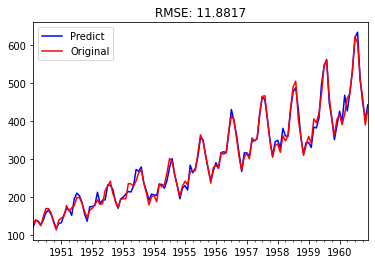

In [18]:
if __name__ == '__main__':
    # df = pd.read_csv('AirPassengers.csv', encoding='utf-8', index_col='date')
    # df.index = pd.to_datetime(df.index)
    # ts = df['x']
    df = pd.read_csv('AirPassengers.csv', encoding='utf-8')
    df.columns = (['date','x']) 
    ts = df.set_index(pd.DatetimeIndex(df['date']))['x'] 
    #чтобы арима не ругалась на отсутствие freq в индексе
    ts.index= pd.DatetimeIndex(ts.index.values,freq=ts.index.inferred_freq)

 
    # предварительная обработка данных
    ts_log = np.log(ts)
    rol_mean = ts_log.rolling(window=12).mean()
    rol_mean.dropna(inplace=True)
    ts_diff_1 = rol_mean.diff(1)
    ts_diff_1.dropna(inplace=True)
    ts_diff_2 = ts_diff_1.diff(1)
    ts_diff_2.dropna(inplace=True)
 
    # модель подходит
    model = arima_model(ts_diff_2)
    #  Здесь используйте параметры модели для автоматической идентификации
    # model.get_proper_model() #автоперебор pq
    model.get_proper_model(0,1) 
    print ('bic:', model.bic, 'p:', model.p, 'q:', model.q)
    print (model.properModel.forecast()[0])
    print (model.forecast_next_day_value(type='month'))
 
    # Восстановление результата прогноза
    predict_ts = model.properModel.predict()
    diff_shift_ts = ts_diff_1.shift(1)
    diff_recover_1 = predict_ts.add(diff_shift_ts)
    rol_shift_ts = rol_mean.shift(1)
    diff_recover = diff_recover_1.add(rol_shift_ts)
    rol_sum = ts_log.rolling(window=11).sum()
    rol_recover = diff_recover*12 - rol_sum.shift(1)
    log_recover = np.exp(rol_recover)
    log_recover.dropna(inplace=True)
 
    # Картирование результатов прогнозирования
    ts = ts[log_recover.index]
    plt.figure(facecolor='white')
    log_recover.plot(color='blue', label='Predict')
    ts.plot(color='red', label='Original')
    plt.legend(loc='best')
    plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
    plt.show()
